In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV




## image_features_extractor

In [2]:
class image_features_extractor:
    def __init__(self    \
        ,color_space = 'HSV'      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        ,orient = 9               # HOG orientations 
        ,pix_per_cell = 7         # HOG pixels per cell 
        ,cell_per_block = 2       # HOG cells per block 
        ,spatial_size = (32, 32)  # Spatial binning dimensions
        ,spatial_feat = True     # Spatial features on or off
        ,hist_feat = True        # Histogram features on or off
        ,hog_feat = True          # HOG features on or off
        ,nbins=32                 # Number of color histogram bins
        ,bins_range=(0, 256)
                ):

        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.nbins=nbins
        self.bins_range=bins_range
        

    # Define a function to compute binned color features  
    def bin_spatial(self,feature_image):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, self.spatial_size).ravel() 
        # Return the feature vector
        return features

    # Define a function to compute color histogram features  
    def color_hist(self,feature_image):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(feature_image[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(feature_image[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(feature_image[:,:,2], bins=self.nbins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    def get_hog_features(self, feature_image, visualise=False):
        if visualise:
            # feature_image is 1 channel image
            hog_features, hog_image     = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
            return hog_features, hog_image

        
        else:
            # feature_image is 1 channel image
            hog_features     = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=True)
            return hog_features



    def get_all_features (self, img):
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)


        img_features = []

        if self.spatial_feat == True:
            img_features.append(self.bin_spatial(feature_image))

        if self.hist_feat == True:
            img_features.append(self.color_hist(feature_image))
            
        if self.hog_feat == True:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                temp = self.get_hog_features(feature_image[:,:,channel])
                hog_features.extend(temp)      
            img_features.append(hog_features)

        #9) Return concatenated array of features
    #     print (img_features)
        return np.concatenate(img_features)                
    

### Car Detector from images ( train & prediction )

In [3]:
class image_car_detector:
    def __init__(self, extractor, 
                 cars_folder='vehicles', 
                 notcars_folder='non-vehicles',
                 limit_images=None):
        self.cars_folder    = cars_folder
        self.notcars_folder = notcars_folder

        self.car_images_list     = []
        self.notcars_images_list = []
        self.extractor = extractor
        
        self.car_features = []
        self.notcar_features = []
        self.limit_images = limit_images

        
    def load_images_list(self):
        self.car_images_list     = []
        self.notcars_images_list = []
    
        # loading cars
        for subfolder in glob.glob(self.cars_folder + '/*'):
          print ("subfolder = " + subfolder)
          for image  in  glob.glob(subfolder+'/*'):
               self.car_images_list.append(image)

        # loading non cars
        for subfolder in glob.glob(self.notcars_folder+ '/*'):
          for image  in  glob.glob(subfolder+'/*'):
               self.notcars_images_list.append(image)
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_imgs_features(self):
        # Iterate through the list of images
        if self.limit_images:
            x_limit = self.limit_images
            print (" limiting the number of images to " + str(x_limit))
        else:
            x_limit = len(self.car_images_list)
            print (" processing " + str(x_limit) +" images "  )


        print ( " ")
        print (" Extracting features from cars ....")
        # CARS FEATURES 
        self.car_features = []


        for file in self.car_images_list[:x_limit]:
            image = cv2.imread('vehicles/GTI_Far/image0022.png')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            self.car_features.append(self.extractor.get_all_features(image))
        print (" .. completed ")

            
        print ( " ")
        print (" Extracting features from non cars ....")
        # NOT CAR FEATURES 
        self.notcar_features = []
        # Iterate through the list of images
        for file in self.notcars_images_list[:x_limit]:
            image = cv2.imread('vehicles/GTI_Far/image0022.png')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.notcar_features.append(self.extractor.get_all_features(image))
        print (" .. completed ")
        print (" ")

        
    def detector_train(self, parameters=[1, 10]):
        print ( "Training ....")
        if len(self.car_features) == 0:
            self.extract_imgs_features()
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)
        
        from sklearn.svm import LinearSVC
        import time

#         self.svr = svm.LinearSVC()


        # Check the training time for the SVC
        print ( "Start training ... ")
        t=time.time()
#         param_grid = {'C': parameters}
#         self.clf = GridSearchCV(self.svr , param_grid=param_grid)
        self.clf = svm.LinearSVC()
        self.clf.fit(X_train, y_train)

        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')

        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.clf.score(X_test, y_test), 4))

    def save_classifier(self):
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'wb') as fid:
            pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'rb') as fid:
            self.clf = pickle.load(fid)
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")    


    def search_windows(self, img, windows):
        self.on_windows = []
        for window in windows:
#             print (window)
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = self.extractor.get_all_features(test_img)
            #5) Scale extracted features to be fed to classifier
            test_features = self.X_scaler.transform(np.array(features).reshape(1, -1))
            
            #6) Predict using your classifier
            prediction = self.clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                self.on_windows.append(window)
#                 print ( "prediction = 1 ")
#                 plt.title("prediction = 1 ")
#             else:
#                 plt.title("prediction = 0 ")

#             plt.axis('off')
#             plt.imshow(test_img)
#             plt.show()


                
        return self.on_windows

            

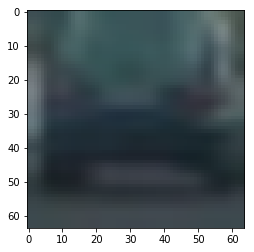

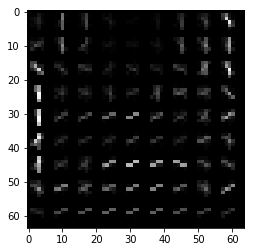

8
(8, 8, 2, 2, 9)


In [9]:
import cv2
image = cv2.imread('vehicles/GTI_Far/image0022.png')
# image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# color space = RGB, HSV, LUV, HLS, YUV, YCrCb
extractor = image_features_extractor(color_space='RGB',
                                     pix_per_cell=7,
                                     cell_per_block=2,
                                     
                                     orient=9)
hog_features, image_tmp = extractor.get_hog_features(image[:,:,2], visualise=True)
plt.imshow(image)
plt.show()
plt.imshow(image_tmp,cmap='gray')
plt.show()
print ( len(hog_features))
print(np.array(hog_features).shape)

In [24]:
extractor = image_features_extractor(color_space='RGB'
                                    ,pix_per_cell=7
                                    ,cell_per_block=2
                                     
                                    ,orient=9
                                    ,spatial_feat = True     # Spatial features on or off
                                    ,hist_feat = True        # Histogram features on or off
                                    ,hog_feat = True  
                                    ,spatial_size = (16, 16)
                                    )



detector = image_car_detector(extractor, limit_images= 100)

detector.load_images_list()

detector.extract_imgs_features()



subfolder = vehicles/GTI_Right
subfolder = vehicles/GTI_MiddleClose
subfolder = vehicles/GTI_Far
subfolder = vehicles/GTI_Left
subfolder = vehicles/KITTI_extracted
 limiting the number of images to 100
 
 Extracting features from cars ....
 .. completed 
 
 Extracting features from non cars ....
 .. completed 
 


In [25]:
len(detector.car_features[0])

7776

In [26]:
detector.detector_train()

detector.save_classifier()

detector.load_classifier()

Training ....
.....Scaling...
Start training ... 
2.44 Seconds to train SVC...
Test Accuracy of SVC =  0.525
 .. classifier saved 
 .. classifier loaded 


In [ ]:
a.append([2,3,4])
a

In [ ]:
class window_extractor:
    def __init__(self, image,               \
                 x_start_stop=[None, None], \
                 y_start_stop=[350, None], \
                 window_dimension=64,  \
                 x_overlap=0.5, y_overlap=0.5):
        
        self.image           = image
        self.xy_window       = (window_dimension, window_dimension)
        self.xy_overlap      = (x_overlap, y_overlap)
        self.x_start_stop    = x_start_stop
        self.y_start_stop    = y_start_stop
        
        # If x and/or y start/stop positions not defined, set to image size
        #     print (x_start_stop)
        if self.x_start_stop[0] == None:
            self.x_start_stop[0] = 0
        if self.x_start_stop[1] == None:
            self.x_start_stop[1] = self.image.shape[1]
        if self.y_start_stop[0] == None:
            self.y_start_stop[0] = 0
        if self.y_start_stop[1] == None:
            self.y_start_stop[1] = self.image.shape[0]

        # Compute the span of the region to be searched    
        self.xspan = self.x_start_stop[1] - self.x_start_stop[0]
        self.yspan = self.y_start_stop[1] - self.y_start_stop[0]
        
        # Compute the number of pixels per step in x/y
        self.nx_pix_per_step = np.int(self.xy_window[0]*(1 - self.xy_overlap[0]))
        self.ny_pix_per_step = np.int(self.xy_window[1]*(1 - self.xy_overlap[1]))
        
        # Compute the number of windows in x/y
        self.nx_buffer = np.int(self.xy_window[0]*(self.xy_overlap[0]))
        self.ny_buffer = np.int(self.xy_window[1]*(self.xy_overlap[1]))
        self.nx_windows = np.int((self.xspan-self.nx_buffer)/self.nx_pix_per_step) 
        self.ny_windows = np.int((self.yspan-self.ny_buffer)/self.ny_pix_per_step) 



    def get_windows(self):
        # Initialize a list to append window positions to
        self.window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(self.ny_windows):
            for xs in range(self.nx_windows):
                # Calculate window position
                startx = xs*self.nx_pix_per_step + self.x_start_stop[0]
                endx = startx + self.xy_window[0]
                starty = ys*self.ny_pix_per_step + self.y_start_stop[0]
                endy = starty + self.xy_window[1]
                # Append window position to list
                self.window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return self.window_list
    
    def draw_boxes(self,hot_windows, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(self.image)
        tmp_window_list = hot_windows
        for bbox in tmp_window_list:
#             print ("bbox = " + str(bbox))
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy

    

In [ ]:
import cv2
image = mpimg.imread('test_images/test1.jpg')

ex1 = window_extractor(image, window_dimension=64)
ex1_windows = ex1.get_windows()
plt.imshow(ex1.draw_boxes(ex1_windows))
plt.show()

ex2 = window_extractor(image, window_dimension=128)
ex2_windows = ex2.get_windows()
plt.imshow(ex2.draw_boxes(ex2_windows))
plt.show()

ex3 = window_extractor(image, window_dimension=int(128*1.5), y_overlap = 0.8)
ex3_windows = ex3.get_windows()
plt.imshow(ex3.draw_boxes(ex3_windows))
plt.show()


ex4 = window_extractor(image, window_dimension=128*2,y_overlap=0.9)
ex4_windows = ex4.get_windows()
plt.imshow(ex4.draw_boxes(ex4_windows))
plt.show()







print ("..... completed")

In [ ]:
import cv2
image = mpimg.imread('test_images/test1.jpg')

windows = []

windows_tmp = window_extractor(image, window_dimension=int(64), y_overlap = 0.7).get_windows()
for x in windows_tmp:
     windows.append(x)

# windows_tmp = window_extractor(image, window_dimension=int(32), y_overlap = 0.5).get_windows()
# for x in windows_tmp:
#      windows.append(x)





# # windows = window_extractor(image, window_dimension=int(128*1.5), y_overlap = 0.4).get_windows()
# for x in window_extractor(image, window_dimension=80).get_windows():
#     windows.append(x)
# for x in window_extractor(image, window_dimension=100).get_windows():
#     windows.append(x)

# for x in window_extractor(image, window_dimension=int(128*1.5)).get_windows():
#     windows.append(x)

hot_windows = detector.search_windows( image, windows_tmp)

plt.imshow(window_extractor(image).draw_boxes(windows_tmp))
plt.show()


plt.imshow(window_extractor(image).draw_boxes(hot_windows))
plt.show()





In [ ]:
from scipy.ndimage.measurements import label

class heat_map:
    def __init__(self, boxes_list, image):
            self.boxes = boxes_list
            self.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
            self.image = np.copy(image)
            
    
    def add_heat(self):
        # Iterate through list of bboxes
        
        for box in self.boxes :
#             print ("box = " + str(box))
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap

    def apply_threshold(self,threshold):
        print (" Applying threshold = " + str(threshold))
        # Zero out pixels below the threshold
        self.heatmap[self.heatmap <= threshold] = 0
        # Return thresholded map

    def draw_labeled_bboxes(self):
        print ("draw_labeled_bboxes .... ")
        #scipy.ndimage.measurements.label
        labels = label(self.heatmap)
        print ("labels = " + str(labels))
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            print ( " car_number = " + str(car_number))
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(self.image, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image


    

In [ ]:
plt.imshow(image)
plt.show()


heat = heat_map(hot_windows, image)
heat.add_heat()
heat.apply_threshold(threshold=2)
heat.draw_labeled_bboxes()
plt.imshow(heat.image)
plt.show()
# print(heat.heatmap.nonzero())


In [ ]:
heat.heatmap[heat.heatmap>0]

In [ ]:
heat.apply_threshold()
print(heat.heatmap.nonzero())

In [ ]:


heat.draw_labeled_bboxes()
plt.imshow(heat.image)
plt.show()

In [ ]:
len(windows)